# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

##### &#9658; [View table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from mls import locate_data

In [3]:
from sklearn import model_selection, neighbors, tree, ensemble

In [4]:
import scipy.stats

## Case Study: Redshift Inference

Our goal is to predict the [cosmological redshift](https://en.wikipedia.org/wiki/Redshift) of a galaxy based on its brightness measured through 17 different filters.  Redshift is a proxy for distance or, equivalently, look back time, so is a key observable for learning about past conditions in the universe.

### Load and Explore Data

Read the data to train and test on:

In [5]:
X = pd.read_hdf(locate_data('photoz_data.hf5'))
y = pd.read_hdf(locate_data('photoz_targets.hf5'))

In [6]:
X.describe()

,CTIO_U,CTIO_U_ERR,VIMOS_U,VIMOS_U_ERR,ACS_F435W,ACS_F435W_ERR,ACS_F606W,ACS_F606W_ERR,ACS_F775W,ACS_F775W_ERR,...,HAWKI_KS,HAWKI_KS_ERR,IRAC_CH1,IRAC_CH1_ERR,IRAC_CH2,IRAC_CH2_ERR,IRAC_CH3,IRAC_CH3_ERR,IRAC_CH4,IRAC_CH4_ERR
count,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,...,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000,17366.000000
mean,0.115481,0.016565,0.122138,0.005541,-3.831100,-3.976799,-0.156267,-0.435271,-0.914184,-1.350993,...,-38.182465,-38.821423,1.621454,0.101949,1.469234,0.087894,1.220399,176.367126,1.041534,13.763525
std,0.337539,0.002894,0.334996,0.001927,19.517122,19.474924,6.818897,6.620780,11.951647,11.560015,...,49.144028,48.354370,5.608161,0.036535,4.562782,0.030426,7.416217,5705.130859,5.302016,880.659851
min,-0.528515,0.000044,-0.069178,0.000013,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,...,-99.000000,-99.000000,-15.660400,0.048871,-11.669100,0.033175,-803.679016,-99.000000,-51.631199,0.233581
25%,0.009948,0.015359,0.009744,0.004570,0.025961,0.007868,0.060697,0.005580,0.076885,0.009418,...,-99.000000,-99.000000,0.186954,0.075382,0.168157,0.070743,0.027263,0.317497,-0.037307,0.337097
50%,0.052541,0.015987,0.057218,0.005313,0.074789,0.012437,0.125512,0.008344,0.166042,0.015086,...,0.094439,0.017297,0.443533,0.099319,0.390066,0.082867,0.384105,0.354340,0.316139,0.375890
75%,0.132249,0.017254,0.138051,0.006295,0.168073,0.017599,0.263416,0.011814,0.366929,0.021948,...,0.400367,0.024287,1.126698,0.116828,1.001483,0.102136,0.997334,0.408356,0.841976,0.439014
max,24.254700,0.052267,22.725800,0.043257,67.487801,2.441870,116.202003,0.195579,207.223999,0.809728,...,351.015991,0.912681,187.001999,0.458180,121.485001,0.341520,85.501999,279307.000000,487.742004,60172.000000


In [7]:
y.describe()

,Z
count,17366.000000
mean,1.990175
std,1.270472
min,0.025000
25%,0.977250
50%,1.773000
75%,2.782750
max,9.824000


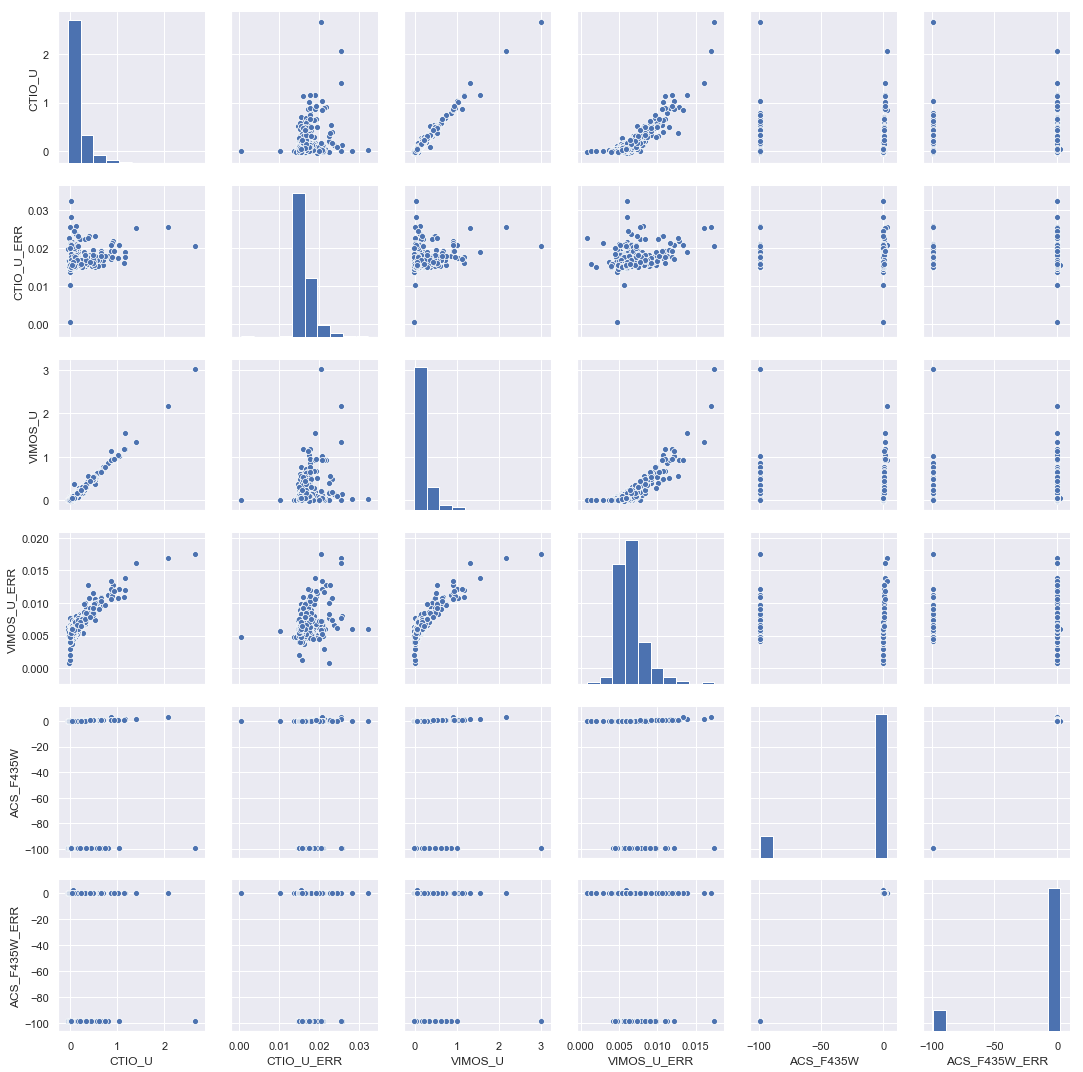

In [8]:
sns.pairplot(X[:500], vars=X.columns.tolist()[:6]);

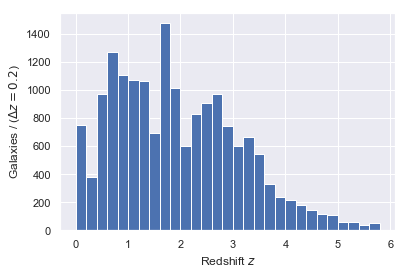

In [9]:
plt.hist(y['Z'], bins=np.arange(0, 6, 0.2))
plt.xlabel('Redshift $z$');
plt.ylabel('Galaxies / ($\Delta z=0.2$)');

### Split Data Randomly into Training and Testing Subsamples

In [10]:
gen = np.random.RandomState(seed=123)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=gen)

In [11]:
print(f'{len(X)} = {len(X_train)} TRAIN + {len(X_test)} TEST')

17366 = 13024 TRAIN + 4342 TEST


### Nearest Neighbor Regression

Use the K-nearest neighbors (KNN) of an input sample to estimate its properties with [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor):

In [12]:
knn_fit = neighbors.KNeighborsRegressor(n_jobs=8).fit(X_train, y_train)

Scores are calculated using the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$, for which perfect accuracy is $R^2 = 1$:

In [13]:
knn_fit.score(X_train, y_train), knn_fit.score(X_test, y_test)

(0.6305155321741681, 0.4180525678164691)

In [14]:
knn_fit.n_neighbors

5

#### Hyperparameter Optimization

The main hyperparameter is the value of K: the number of nearest neighbors that contribute to the final decision.

In [15]:
def knn_study(n=(1, 2, 4, 6, 8, 12, 16), max_score_samples=2000):
    train_score, test_score = [], []
    for n_neighbors in n:
        fit = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=8).fit(X_train, y_train)
        train_score.append(fit.score(X_train[:max_score_samples], y_train[:max_score_samples]))
        test_score.append(fit.score(X_test[:max_score_samples], y_test[:max_score_samples]))
    plt.plot(n, train_score, 'rx-', label='TRAIN')
    plt.plot(n, test_score, 'bo-', label='TEST')
    plt.xlabel('KNN n_neighbors')
    plt.ylabel('KNN $R^2$ score')
    plt.legend()

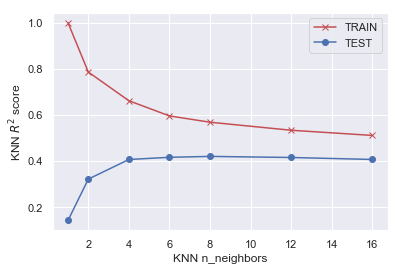

In [16]:
knn_study()

### Decision Tree Regression

Use a [binary decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) to sort each input sample into a small "peer group" with [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Note the similarity with KNN, except now we ask a set of questions to identify the "peer group", instead of using nearest neighbors.

In [17]:
gen = np.random.RandomState(seed=123)
tree_fit = tree.DecisionTreeRegressor(random_state=gen).fit(X_train, y_train)

In [18]:
tree_fit.score(X_train, y_train), tree_fit.score(X_test, y_test)

(1.0, 0.745754528682889)

In [19]:
tree_fit.tree_.max_depth

34

#### Feature Importance

In [20]:
importance = pd.DataFrame(
    {'feature': X.columns, 'importance': tree_fit.feature_importances_}
).sort_values(by='importance', ascending=False)

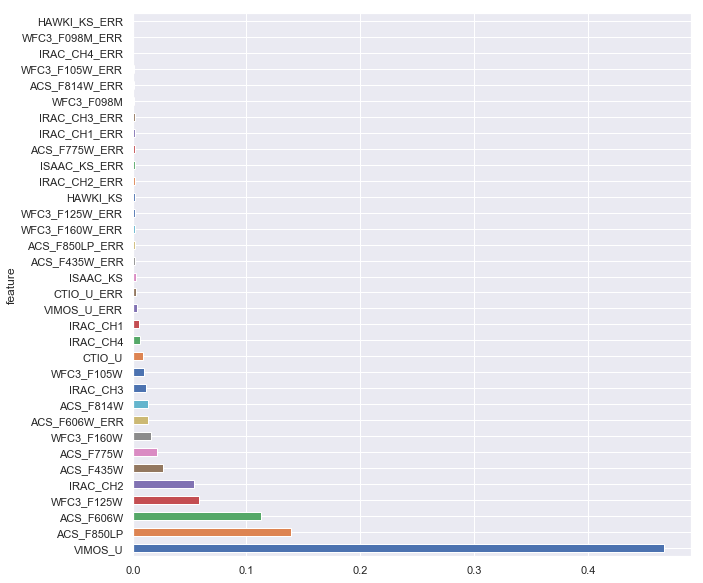

In [21]:
importance.plot('feature', 'importance', 'barh', figsize=(10, 10), legend=False);

Re-train using only the 8 most important features:

In [22]:
importance[:8]

,feature,importance
2,VIMOS_U,0.467002
12,ACS_F850LP,0.139219
6,ACS_F606W,0.112596
18,WFC3_F125W,0.058217
28,IRAC_CH2,0.054210
4,ACS_F435W,0.026314
8,ACS_F775W,0.021706
20,WFC3_F160W,0.015878


In [23]:
best_features = importance[:8]['feature']

The re-trained tree is much simpler and almost equally accurate on the test data:

In [24]:
tree_fit = tree.DecisionTreeRegressor(random_state=gen).fit(X_train[best_features], y_train)
tree_fit.score(X_train[best_features], y_train), tree_fit.score(X_test[best_features], y_test)

(1.0, 0.7381381023225613)

In [25]:
tree_fit.tree_.max_depth

35

#### Hyperparameter Optimization

In [26]:
def tree_study(n=(3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 35), seed=123):
    gen = np.random.RandomState(seed)
    train_score, test_score = [], []
    for max_depth in n:
        fit = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=gen).fit(X_train[best_features], y_train)
        train_score.append(fit.score(X_train[best_features], y_train))
        test_score.append(fit.score(X_test[best_features], y_test))
    plt.plot(n, train_score, 'rx-', label='TRAIN')
    plt.plot(n, test_score, 'bo-', label='TEST')
    plt.xlabel('DecisionTree max_depth')
    plt.ylabel('DecisionTree $R^2$ score')
    plt.legend()

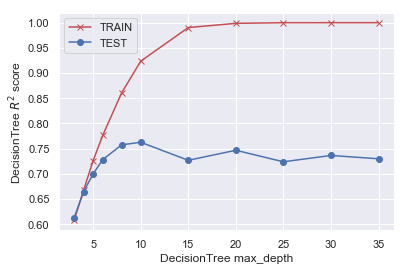

In [27]:
tree_study()

Chose a `max_depth` of 5 to minimize overfitting the training data (or choose 10 to balance overfitting with accuracy on the test data):

In [28]:
gen = np.random.RandomState(seed=123)
tree_fit = tree.DecisionTreeRegressor(max_depth=5, random_state=gen).fit(X_train[best_features], y_train)
tree_fit.score(X_train[best_features], y_train), tree_fit.score(X_test[best_features], y_test)

(0.7262743028011795, 0.699983128890002)

Note that a tree of depth $n$ sorts each sample into one of $2^n$ leaf nodes, each with a fixed prediction. This leads to a visible discretization error for small $n$, which is not necessarily a problem if the uncertainties are even larger:

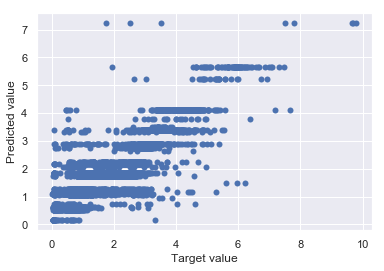

In [29]:
y_predict = tree_fit.predict(X_test[best_features])
plt.scatter(y_test, y_predict, lw=0)
plt.xlabel('Target value')
plt.ylabel('Predicted value');

#### Tree Visualization

In [30]:
tree.export_graphviz(tree_fit, out_file='tree.dot')

In [31]:
!dot -Tpng tree.dot -o tree.png

In [32]:
def plot_branch(path=[], fit=tree_fit, X=X_train[best_features], y=y_train.values):
    tree = fit.tree_
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    # Traverse the tree using the specified path.
    node = 0
    sel = np.ones(len(X), bool)
    cut = threshold[node] 
    x = X.iloc[:, feature[node]]
    print('nsel', np.count_nonzero(sel), 'cut', cut, 'value', np.mean(y[sel]))
    for below_threshold in path:
        if below_threshold:
            sel = sel & (x <= cut)
            node = children_left[node]
        else:
            sel = sel & (x > cut)
            node = children_right[node]
        cut = threshold[node] 
        x = X.iloc[:, feature[node]]
        print('nsel', np.count_nonzero(sel), 'cut', cut, 'value', np.mean(y[sel]))
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    xlim = np.percentile(x[sel], (1, 95))
    below = sel & (x <= cut)
    above = sel & (x > cut)
    ax[0].hist(x[below], range=xlim, bins=50, histtype='stepfilled', color='r', alpha=0.5)
    ax[0].hist(x[above], range=xlim, bins=50, histtype='stepfilled', color='b', alpha=0.5)
    ax[0].set_xlim(*xlim)
    ax[0].set_xlabel(X.columns[feature[node]])
    ylim = np.percentile(y, (1, 99))
    y_pred = np.empty_like(y)
    y_pred[below] = np.mean(y[below])
    y_pred[above] = np.mean(y[above])    
    mse2 = np.mean((y[sel] - y_pred[sel]) ** 2)
    n_below = np.count_nonzero(below)
    n_above = np.count_nonzero(above)
    mse = (np.var(y[below]) * n_below  + np.var(y[above]) * n_above) / (n_below + n_above)
    #print('mse', mse, mse2)
    ax[1].hist(y[below], range=ylim, bins=25, histtype='stepfilled', color='r', alpha=0.5)
    ax[1].axvline(np.mean(y[below]), c='r', ls='--')
    ax[1].hist(y[above], range=ylim, bins=25, histtype='stepfilled', color='b', alpha=0.5)
    ax[1].axvline(np.mean(y[above]), c='b', ls='--')
    ax[1].set_xlabel('Redshift target')

nsel 13024 cut 0.007975295186042786 value 1.9733001


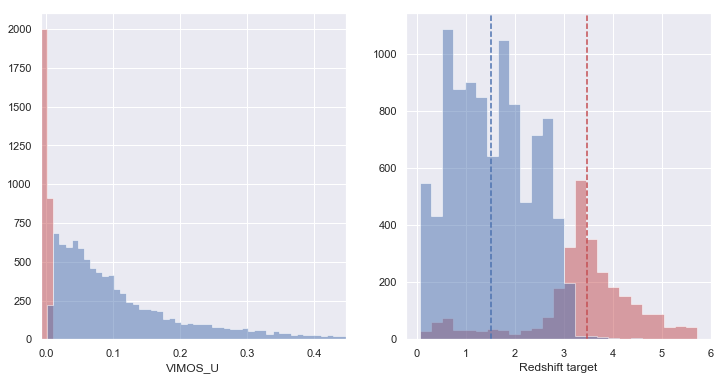

In [33]:
plot_branch([])

nsel 13024 cut 0.007975295186042786 value 1.9733001
nsel 3044 cut 0.008564084768295288 value 3.4734519


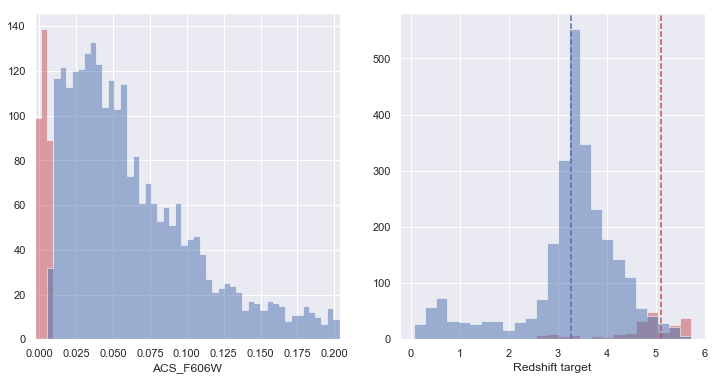

In [34]:
plot_branch([True,])

nsel 13024 cut 0.007975295186042786 value 1.9733001
nsel 9980 cut 0.28916649520397186 value 1.5157386


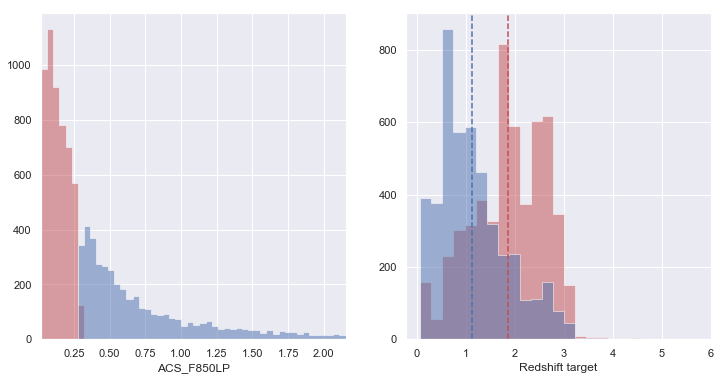

In [35]:
plot_branch([False,])

### Random Forest Regression

Use an ensemble of decision trees that are individually less accurate but collectively more accurate, with [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). The individual trees are trained on random sub-samples of the data and the resulting "forest" of predictions are averaged. The random subsets for each tree are created by:
 - Using a "bootstrap" resampling of the rows, and
 - Finding the best split at each branch from a random subset of `max_features` features (columns).

In [36]:
gen = np.random.RandomState(seed=123)
forest_fit = ensemble.RandomForestRegressor(
    n_estimators=15, max_features=0.5, random_state=gen, n_jobs=8).fit(X_train, y_train.values.reshape(-1))

In [37]:
forest_fit.score(X_train, y_train), forest_fit.score(X_test, y_test)

(0.9763620168915049, 0.8630589304956074)

Compare the first branch for two of the trees in our forest:

nsel 13024 cut 0.01966005004942417 value 1.9733001


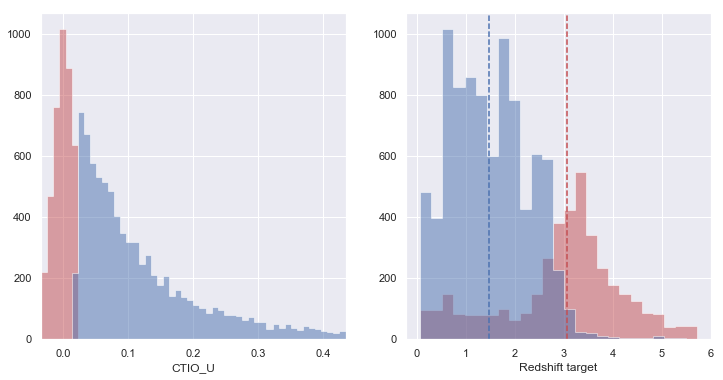

In [38]:
plot_branch(fit=forest_fit.estimators_[0], X=X_train)

nsel 13024 cut 0.0073961850721389055 value 1.9733001


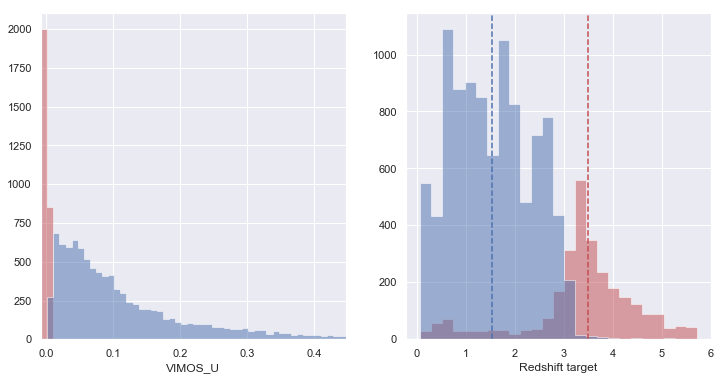

In [39]:
plot_branch(fit=forest_fit.estimators_[1], X=X_train)

#### Hyperparameter Optimization

In [40]:
def forest_study(n=(1, 2, 3, 5, 10, 15, 20, 25, 30), seed=123):
    gen = np.random.RandomState(seed)
    train_score, test_score = [], []
    for n_estimators in n:
        fit = ensemble.RandomForestRegressor(
            n_estimators=n_estimators, max_features=0.5, random_state=gen, n_jobs=8).fit(
            X_train, y_train.values.reshape(-1))
        train_score.append(fit.score(X_train, y_train))
        test_score.append(fit.score(X_test, y_test))
    plt.plot(n, train_score, 'rx-', label='TRAIN')
    plt.plot(n, test_score, 'bo-', label='TEST')
    plt.xlabel('RandomForest n_estimators')
    plt.ylabel('RandomForest $R^2$ score')
    plt.legend()

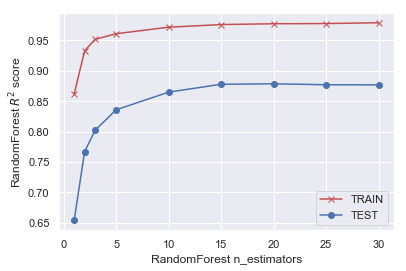

In [41]:
forest_study()

#### Feature Importance (again)

In [42]:
importance = pd.DataFrame(
    {'feature': X.columns, 'importance': forest_fit.feature_importances_}
).sort_values(by='importance', ascending=False)

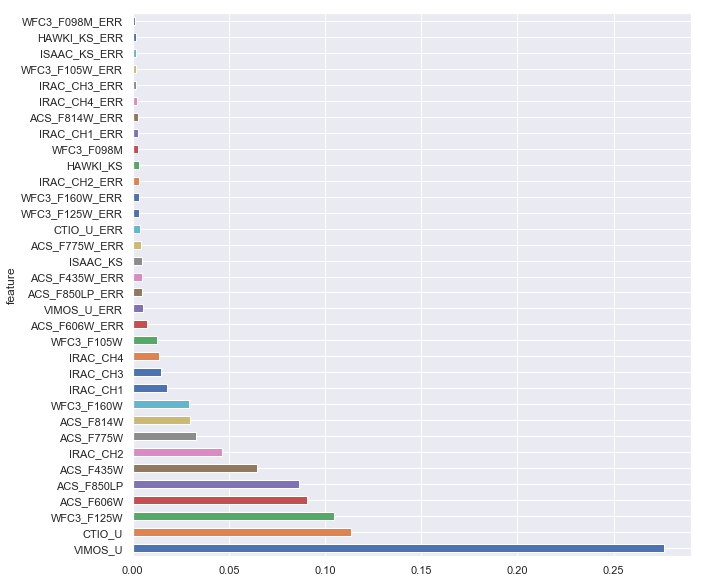

In [43]:
importance.plot('feature', 'importance', 'barh', figsize=(10, 10), legend=False);

#### Prediction uncertainty

Since we now have multiple predictions for each sample, we can use their spread as an estimate of the uncertainty in the mean prediction:

In [44]:
y_pred = forest_fit.predict(X_test)

In [45]:
y_pred_each = np.array([tree.predict(X_test) for tree in forest_fit.estimators_])
y_pred_each.shape

(15, 4342)

In [46]:
np.all(y_pred == np.mean(y_pred_each, axis=0))

True

In [47]:
y_pred_error = y_test.values.reshape(-1) - y_pred
y_pred_spread = np.std(y_pred_each, axis=0)

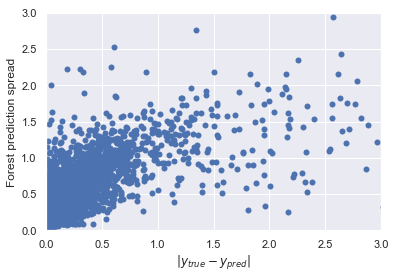

In [48]:
plt.scatter(np.abs(y_pred_error), y_pred_spread, lw=0)
plt.xlabel('$|y_{true} - y_{pred}|$')
plt.ylabel('Forest prediction spread')
plt.xlim(0, 3)
plt.ylim(0, 3);

Text(0.5, 0, 'pull = dy / $\\sigma$')

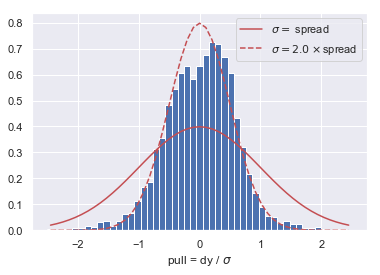

In [70]:
bins = np.linspace(-2.5, 2.5, 50)
plt.hist(y_pred_error / y_pred_spread, bins=bins, density=True)
pull = 0.5 * (bins[1:] + bins[:-1])
plt.plot(pull, scipy.stats.norm.pdf(pull), 'r-', label='$\sigma=$ spread')
correction = 2.0
plt.plot(pull, correction * scipy.stats.norm.pdf(correction * pull), 'r--',
         label=('$\sigma=%.1f \\times$' % correction) + 'spread')
plt.legend()
plt.xlabel('pull = dy / $\sigma$')

#### "Out-of-bag" Testing

Combining the trees in a forest is known as "bagging".  Since each tree leaves out some samples, we can use these omitted (aka "out-of-bag") samples to test our model. This means we no longer need to set aside a separate test dataset and can use all of our data for training the forest.

*Technical note: since RandomForestRegressor does not support a max_samples parameter, the out-of-bag samples are only due to bootstrap sampling with replacement, which generally needs more estimators for reasonable statistics.*

In [50]:
gen = np.random.RandomState(seed=123)
forest_fit = ensemble.RandomForestRegressor(
    n_estimators=100, max_features=0.5, oob_score=True, random_state=gen, n_jobs=8).fit(X, y.values.reshape(-1))

In [51]:
forest_fit.score(X_train, y_train), forest_fit.oob_score_

(0.982570310465904, 0.8767722201664717)